In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../..")

In [4]:
import deepmatcher as dm
import pandas as pd

## Dataset creation

In [18]:
model = dm.MatchingModel(attr_summarizer='rnn')
model.load_state('../../models/walmartamazon_rnn.pth')

In [6]:
from utilities_functions.intermediate_layer_extraction import return_layer_input

In [8]:
neg_classifier_inputs,neg_ids = return_layer_input('../../Structured/Walmart-Amazon/','negatives',
                                                  batch_size=512,model=model,
                                                   layer=model.classifier,
                                                  device=-1)

In [9]:
pos_classifier_inputs,pos_ids = return_layer_input('../../Structured/Walmart-Amazon/','positives',
                                                  batch_size=512,model=model,
                                                  layer=model.classifier,
                                                  device=-1)

In [19]:
testneg_classifier,testneg_ids = return_layer_input('../../Structured/Walmart-Amazon/','test_negatives',
                                                  batch_size=128,model=model,
                                                   layer=model.classifier,
                                                  device=-1)

In [20]:
testpos_classifier,testpos_ids = return_layer_input('../../Structured/Walmart-Amazon/','test_positives',
                                                  batch_size=128,model=model,
                                                  layer=model.classifier,
                                                  device=-1)

In [21]:
model = model.cuda()

## Ri discovery

### Negative samples analysis

In [22]:
from utilities_functions.ri_calculator import computeRi

In [23]:
attributes =['title','category','brand','modelno','price']
classifier_len = len(pos_classifier_inputs[0][0])
attribute_len = int(classifier_len/len(attributes))

In [25]:
neg_ri,neg_ri_norms = computeRi(model.classifier,attributes,testneg_classifier,attribute_len,1)


100%|██████████| 128/128 [00:15<00:00,  8.04it/s]

100%|██████████| 128/128 [00:15<00:00,  8.34it/s]

100%|██████████| 64/64 [00:07<00:00,  8.56it/s]

100%|██████████| 128/128 [00:15<00:00,  8.29it/s]

 33%|███▎      | 42/128 [00:04<00:13,  6.16it/s]


100%|██████████| 128/128 [00:14<00:00,  8.64it/s]

100%|██████████| 128/128 [00:13<00:00,  9.21it/s]

100%|██████████| 128/128 [00:14<00:00,  9.01it/s]

100%|██████████| 128/128 [00:12<00:00, 10.01it/s]

 73%|███████▎  | 94/128 [00:09<00:04,  7.86it/s]


100%|██████████| 128/128 [00:13<00:00,  9.28it/s]

100%|██████████| 128/128 [00:14<00:00,  8.73it/s]

100%|██████████| 128/128 [00:17<00:00,  7.22it/s]

100%|██████████| 128/128 [00:17<00:00,  7.28it/s]

 43%|████▎     | 55/128 [00:06<00:08,  8.62it/s]


100%|██████████| 128/128 [00:14<00:00,  8.76it/s]

100%|██████████| 128/128 [00:14<00:00,  9.14it/s]

100%|██████████| 128/128 [00:14<00:00,  8.74it/s]


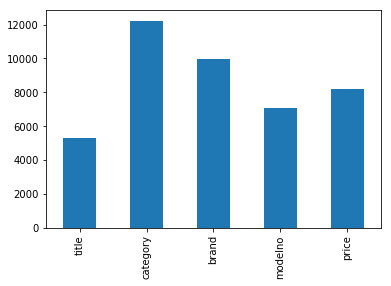

In [26]:
negatives_variation_df = pd.DataFrame(data= neg_ri_norms,columns=attributes)
negatives_variation_df.sum().plot.bar()

In [27]:
negatives_variation_df.to_csv('experiment_results/testnegatives_ri_rnn.csv',index=False)

### Positive samples analysis

In [28]:
pos_ri,pos_ri_norms = computeRi(model.classifier,attributes,testpos_classifier,attribute_len,0)


100%|██████████| 128/128 [00:03<00:00, 34.49it/s]

100%|██████████| 65/65 [00:01<00:00, 42.78it/s]


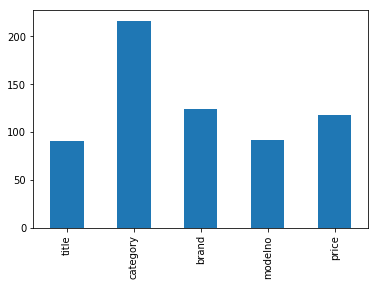

In [29]:
positives_variation_df = pd.DataFrame(data= pos_ri_norms,columns=attributes)
positives_variation_df.sum(numeric_only=True).plot.bar()

In [30]:
positives_variation_df.to_csv('experiment_results/testpositives_ri_rnn.csv',index=False)

## Nearest neighbors

In [31]:
from utilities_functions.distance_measures import calculate_nearest_neighbors_onAttributes

In [34]:
positives_nn = calculate_nearest_neighbors_onAttributes(testpos_classifier,testpos_ids,pos_ri,
                                                       neg_classifier_inputs,neg_ids,attributes,attribute_len)


100%|██████████| 128/128 [00:01<00:00, 110.94it/s]

100%|██████████| 65/65 [00:00<00:00, 144.86it/s]


In [35]:
negatives_nn = calculate_nearest_neighbors_onAttributes(testneg_classifier,testneg_ids,
                                                              neg_ri,pos_classifier_inputs,
                                                              pos_ids,attributes,attribute_len)


100%|██████████| 128/128 [00:00<00:00, 321.66it/s][A

100%|██████████| 128/128 [00:00<00:00, 365.08it/s]

100%|██████████| 64/64 [00:00<00:00, 422.26it/s]

100%|██████████| 128/128 [00:00<00:00, 422.80it/s][A

100%|██████████| 128/128 [00:00<00:00, 422.83it/s]

100%|██████████| 128/128 [00:00<00:00, 430.08it/s][A

100%|██████████| 128/128 [00:00<00:00, 440.25it/s][A

100%|██████████| 128/128 [00:00<00:00, 444.61it/s][A

100%|██████████| 128/128 [00:00<00:00, 445.75it/s][A

100%|██████████| 128/128 [00:00<00:00, 449.88it/s][A

100%|██████████| 128/128 [00:00<00:00, 443.36it/s][A

100%|██████████| 128/128 [00:00<00:00, 442.52it/s][A

100%|██████████| 128/128 [00:00<00:00, 444.98it/s][A

100%|██████████| 128/128 [00:00<00:00, 436.19it/s][A

100%|██████████| 128/128 [00:00<00:00, 441.94it/s][A


In [37]:
negatives_nn.to_csv('experiment_results/testneg_nn_rnn.csv',index=False)
positives_nn.to_csv('experiment_results/testpos_nn_rnn.csv',index=False)